# Testing Assumptions in model with DoWhy: A simple example
This is a quick introduction to how we can test if our assumed graph is correct and the assumptions match with the dataset.
We do so by checking the conditional independences in the graph and see if they hold true for the data as well. Currently we are using partial correlation to test continuous data and conditional mutual information to test discrete data

First, let us load all required packages.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy
from dowhy import CausalModel
import dowhy.datasets 

## Step 1: Load dataset

In [3]:
#generate_dataset function creates a dataset for a randomly generated directed graph. 
#The data can be discrete as well as continuous
data = dowhy.datasets.dataset_from_random_graph(num_vars = 10,
                                                num_samples = 5000,
                                                prob_edge = 0.3,
                                                random_seed = 100)
df = data["df"] #Insert dataset here
print(data["discrete_columns"], data["continuous_columns"])
print(df.head())

['j', 'b', 'e', 'f', 'g', 'h'] ['a', 'i', 'c', 'd']
          a         i  j  b  e  f         c  g  h         d
0 -0.156287 -0.949734  0  0  0  1  1.451789  0 -2  2.350472
1 -0.341762  0.736139  1  0  1  0  0.165234  1  0 -0.373310
2  0.818730  0.925713  0  2  0  1 -1.642960  0  1  0.555383
3 -0.092614  0.485009  0  0  1  0 -1.500991  0  0 -1.087590
4  0.508081  0.102928  0 -1  0  1 -0.175290  0  0  1.084673


Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Step 2: Input causal graph

We now input a causal graph. You can do that in the GML graph format (recommended), DOT format or the output from daggity -
To create the causal graph for your dataset, you can use a tool like [DAGitty](http://dagitty.net/dags.html#) that provides a GUI to construct the graph. You can export the graph string that it generates.

In [4]:
graph_string = """graph [
  directed 1
  node [
    id 0
    label "a"
  ]
  node [
    id 1
    label "b"
  ]
  node [
    id 2
    label "c"
  ]
  node [
    id 3
    label "d"
  ]
  node [
    id 4
    label "e"
  ]
  node [
    id 5
    label "f"
  ]
  node [
    id 6
    label "g"
  ]
  node [
    id 7
    label "h"
  ]
  node [
    id 8
    label "i"
  ]
  node [
    id 9
    label "j"
  ]
  edge [
    source 0
    target 1
  ]
  edge [
    source 0
    target 2
  ]
  edge [
    source 0
    target 3
  ]
  edge [
    source 1
    target 4
  ]
  edge [
    source 1
    target 5
  ]
  edge [
    source 1
    target 3
  ]
  edge [
    source 2
    target 3
  ]
  edge [
    source 4
    target 2
  ]
  edge [
    source 4
    target 5
  ]
  edge [
    source 4
    target 6
  ]
  edge [
    source 4
    target 7
  ]
  edge [
    source 8
    target 6
  ]
  edge [
    source 8
    target 7
  ]
  edge [
    source 9
    target 5
  ]
  edge [
    source 9
    target 6
  ]
  edge [
    source 9
    target 3
  ]
  edge [
    source 9
    target 7
  ]
]
"""

## Step 3: Create Causal Model

In [5]:
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=graph_string
        )

In [6]:
model.view_model()

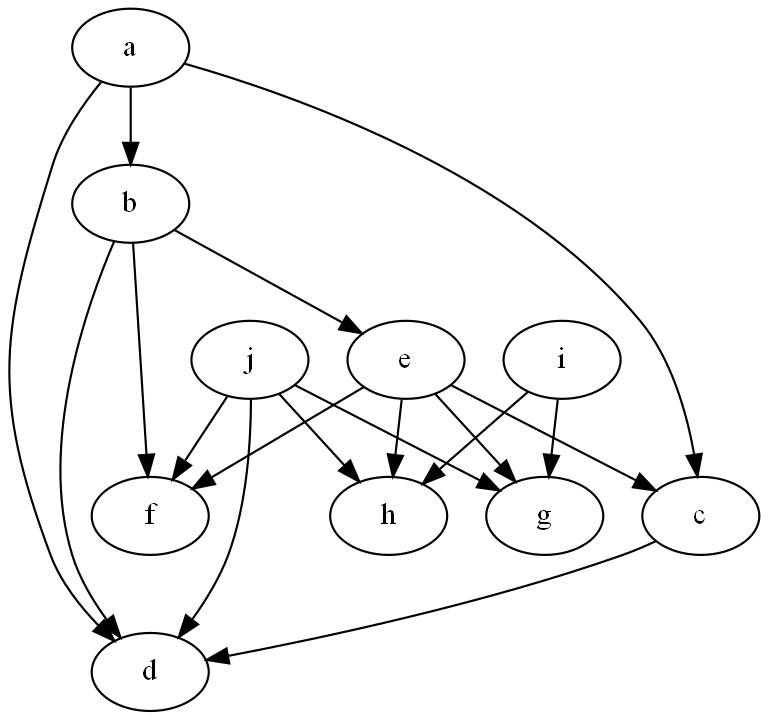

In [7]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step 4: Testing for Conditional Independence
We can check if the assumptions of the graph hold true for the data using<br> `model.refute_graph(k, independence_test = {'test_for_continuous': 'partial_correlation', 'test_for_discrete' : 'conditional_mutual_information'})` <br>
We are testing X ⫫ Y | Z where X and Y are singular sets and Z can have k number of variables. <br>
Currently we are using "partial_correlation" method for testing continuous data and "conditional_mutual_information" for discrete data by default and k value is 1 by default unless input. For constraints having mixed type of data (continuous and discrete), partial correlation is used.

In [8]:
refuter_object = model.refute_graph(k=1, independence_test = {'test_for_continuous': 'partial_correlation', 'test_for_discrete' : 'conditional_mutual_information'}) #Change k parameter to test conditional independence given different number of variables 

Error
Error
Error


In [9]:
print(refuter_object)

Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:68
Number of independences satisfied by data:62
Test passed:False



### Testing for a set of edges
We can also test a set of conditional independences whether they are true or not The input has to be in the form - <br>
[( x1, y1, (z1, z2)), <br>
 ( x2, y2, (z3, z4)),<br>
 ( x3, y3, (z5,)),<br>
 ( x4, y4, ())<br>
 ]<br>
 ##### The testing data can be a mix of discrete and continuous types as well (Here binary implies discrete only) -

In [10]:
refuter_object = model.refute_graph(independence_constraints = [('i', 'd' , ('f',)), # i and d - continuous, f - binary
                                                                ('i', 'f' , ('e',)), # i - continuous, f - binary, e - binary
                                                                ('j', 'b' , ('c',)), # j and b - discrete, c - continuous
                                                                ('j', 'i' , ('b',)), # j - binary, i - continuous, b - discrete
                                                                ('j', 'a' , ('e',)) # j - binary, a - continuous, e - binary
                                                               ],
                         independence_test = {'test_for_continuous': 'partial_correlation', 'test_for_discrete' : 'conditional_mutual_information'}
                        )

In [11]:
print(refuter_object)

Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:5
Number of independences satisfied by data:5
Test passed:True



## Testing with a wrong graph input

In [12]:
graph_string = """graph [
        directed 1
        node [
            id 0
            label "a"
        ]
        node [
            id 1
            label "b"
        ]
        node [
            id 2
            label "c"
        ]
        node [
            id 3
            label "d"
        ]
        node [
            id 4
            label "e"
        ]
        node [
            id 5
            label "f"
        ]
        node [
            id 6
            label "g"
        ]
        node [
            id 7
            label "h"
        ]
        node [
            id 8
            label "i"
        ]
        node [
            id 9
            label "j"
        ]
        edge [
            source 0
            target 1
        ]
        edge [
            source 0
            target 2
        ]
        edge [
            source 0
            target 3
        ]
        edge [
            source 1
            target 4
        ]
        edge [
            source 1
            target 5
        ]
        edge [
            source 2
            target 3
        ]
        edge [
            source 4
            target 2
        ]
        edge [
            source 4
            target 5
        ]
        edge [
            source 4
            target 6
        ]
        edge [
            source 4
            target 7
        ]
        edge [
            source 8
            target 6
        ]
        edge
        [
        source 9
        target 0
        ]
        ]"""

In [13]:
model = CausalModel(
            data=df,
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=graph_string,
        )

In [14]:
model.view_model()

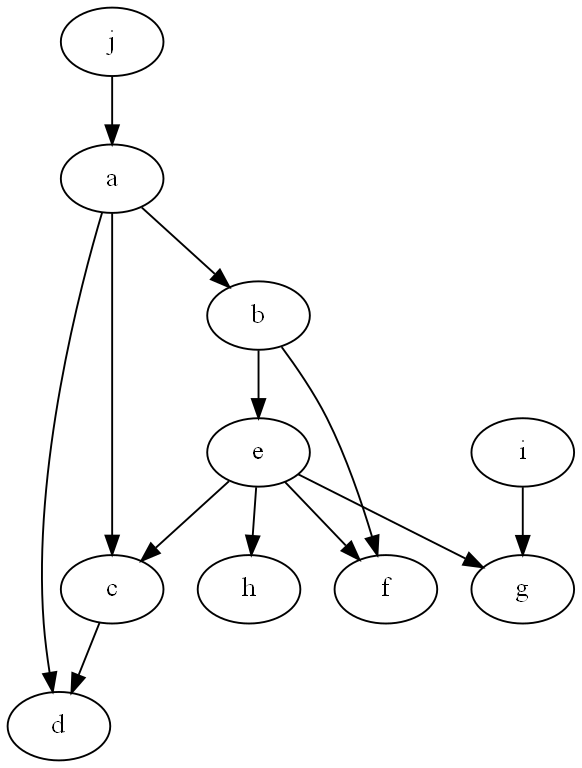

In [15]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [16]:
refuter_object = model.refute_graph(k=2)

f bin
i cont
('h', 'c') mixed
f bin
i cont
('h', 'd') mixed
f bin
i cont
('h', 'a') mixed
f bin
i cont
('c', 'b') mixed
f bin
i cont
('d', 'b') mixed
f bin
i cont
('a', 'b') mixed
f bin
a cont
('i', 'b') mixed
j bin
i cont
('h', 'c') mixed
j bin
i cont
('h', 'd') mixed
j bin
i cont
('h', 'a') mixed
j bin
i cont
('c', 'b') mixed
j bin
i cont
('d', 'b') mixed
j bin
i cont
('a', 'b') mixed
j bin
c cont
('h', 'a') mixed
j bin
c cont
('a', 'b') mixed
j bin
d cont
('h', 'a') mixed
j bin
d cont
('a', 'b') mixed
h dis
i cont
('f', 'c') mixed
h dis
i cont
('f', 'd') mixed
h dis
i cont
('f', 'a') mixed
h dis
i cont
('j', 'c') mixed
h dis
i cont
('j', 'd') mixed
h dis
i cont
('j', 'a') mixed
h dis
i cont
('c', 'e') mixed
Error
Error
h dis
i cont
('c', 'b') mixed
h dis
i cont
('e', 'd') mixed
h dis
i cont
('e', 'a') mixed
Error
h dis
i cont
('d', 'b') mixed
h dis
i cont
('a', 'b') mixed
h dis
c cont
('i', 'e') mixed
h dis
c cont
('e', 'd') mixed
h dis
c cont
('e', 'a') mixed
h dis
d cont
('i', 'e'

We can see that since we input the wrong graph, many conditional independences were not met

In [17]:
print(refuter_object)

Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:359
Number of independences satisfied by data:256
Test passed:False

